In [ ]:
# Mount google drive to access google drive on colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWipsl-t7a74nYTqZjVvgKS2OxnnIb2RoLBzh4z_gyerSvAfeINEspE
Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/sarcasm_data"

LR.png		sarcasm_test.csv   sarcasm_valid.csv
prediction.csv	sarcasm_train.csv  SVM.png


In [ ]:
%cd /content/drive/My Drive/sarcasm_data 

/content/drive/My Drive/sarcasm_data


In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train = pd.read_csv('sarcasm_train.csv',engine='python')
test = pd.read_csv('sarcasm_test.csv',engine='python')
valid = pd.read_csv('sarcasm_valid.csv', engine='python')
train_valid = pd.read_csv('sarcasm_train_valid.csv', engine='python')
train.head(5)
train.describe

<bound method NDFrame.describe of         label  ...                           parent_comment_processed
0           0  ...                            we are all going to die
1           1  ...  nonamericans of reddit what are some examples ...
2           1  ...                                           gif dump
3           0  ...  best car for a moron to be honest i dont think...
4           1  ...  so theres a treaty that no country are able to...
...       ...  ...                                                ...
909690      0  ...                          what if its a stolen ship
909691      1  ...                                picture of the code
909692      0  ...  same here and thats what i love about it the s...
909693      0  ...  christmas is going to be amazing at my fatheri...
909694      0  ...               perhaps itll show up again as a skin

[909695 rows x 11 columns]>

In [ ]:
test.describe

<bound method NDFrame.describe of         label  ...                           parent_comment_processed
0           0  ...  hillarys surrogotes told to blame media for de...
1           0  ...  thank god liberals like to live in concentrate...
2           0  ...           saw this cutie training his attack today
3           0  ...  if you were locked in a room with 49 other peo...
4           0  ...                         youre not even that pretty
...       ...  ...                                                ...
251589      1  ...  arent you a little old to be on the internet g...
251590      1  ...  im sorry i cant hear you over the sound of how...
251591      1  ...                                     so far so lame
251592      1  ...                      i dont care says lapland boss
251593      1  ...  when their efforts failed as they usually did ...

[251594 rows x 11 columns]>

In [ ]:
#train = train.dropna()
#test = test.dropna()
#valid = valid.dropna()

train.fillna('', inplace=True)
valid.fillna('', inplace=True)
test.fillna('', inplace=True)
train_valid.fillna('', inplace=True)

In [ ]:
train.describe

<bound method NDFrame.describe of         label  ...                           parent_comment_processed
0           0  ...                            we are all going to die
1           1  ...  nonamericans of reddit what are some examples ...
2           1  ...                                           gif dump
3           0  ...  best car for a moron to be honest i dont think...
4           1  ...  so theres a treaty that no country are able to...
...       ...  ...                                                ...
909690      0  ...                          what if its a stolen ship
909691      1  ...                                picture of the code
909692      0  ...  same here and thats what i love about it the s...
909693      0  ...  christmas is going to be amazing at my fatheri...
909694      0  ...               perhaps itll show up again as a skin

[909695 rows x 11 columns]>

In [ ]:
#convert to string
train['comment_processed'] = train['comment_processed'].apply(str)

In [ ]:
train['comment_processed']

0                                                eventually
1                                      the average american
2         not sure if i can handle all of that edge in t...
3                                                 crown vic
4         no humans are clearly above using military pow...
                                ...                        
909690    i think right now the owner of said stolen shi...
909691         oh you have the code but do you have the pin
909692                                            shoeflake
909693    most expensive and trollish would be the hills...
909694                                             this pls
Name: comment_processed, Length: 909695, dtype: object

In [ ]:
new_train = train.drop(['label', 'comment', 'ups', 'downs', 'parent_comment', 'parent_comment_processed'], axis=1)

In [ ]:
new_test = test.drop(['label', 'comment', 'ups', 'downs', 'parent_comment', 'parent_comment_processed'], axis=1)

In [ ]:
new_train.head()


,score,word_count,capitilised_frequency,punctuation_frequency,comment_processed
0,18,1,0.000000,0.166667,eventually
1,-1,3,0.095238,0.047619,the average american
2,15,15,0.041667,0.013889,not sure if i can handle all of that edge in t...
3,13,2,0.200000,0.100000,crown vic
4,3,16,0.010309,0.010309,no humans are clearly above using military pow...


In [ ]:
new_test.head()

,score,word_count,capitilised_frequency,punctuation_frequency,comment_processed
0,3,17,0.038462,0.048077,actually most of her supporters and sane peopl...
1,13,12,0.028571,0.028571,they cant survive without an echo chamber whic...
2,8,6,0.000000,0.026316,youre pretty cute yourself 1729 total
3,2,9,0.023256,0.023256,if you kill me youll crash the meme market
4,5,11,0.019608,0.019608,i bet he wrote that last message as he was sob...


### Lemmatization of comment_processed

In [ ]:
lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



# Lemmatizing
train['lemmatized'] = train['comment_processed'].apply(lambda x: lemmatize_sentence(x))
test['lemmatized'] = test['comment_processed'].apply(lambda x: lemmatize_sentence(x))
valid['lemmatized'] = valid['comment_processed'].apply(lambda x: lemmatize_sentence(x))
train_valid['lemmatized'] = train_valid['comment_processed'].apply(lambda x: lemmatize_sentence(x))

# Source:
# https://stackoverflow.com/questions/51267166/lemmatization-pandas-python

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
linear_svm = svm.LinearSVC()

###Create pipeline for tfidf and linear svm

In [ ]:
tfidf_pipeline = Pipeline([('tf_idf', tfidf), 
                                 ('linear_svm', linear_svm)])

## **Method 1: Use only a single feature - comment_processed, to fit into the model**

In [ ]:
tfidf_pipeline.fit(train['lemmatized'], train['label'])

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('linear_svm', LinearSVC())])

### Evaluation on validation set 

In [ ]:
valid_pred = tfidf_pipeline.predict(valid['lemmatized'])
accuracy_score(valid['label'], valid_pred)

0.7146659015809573

In [ ]:
print(classification_report(valid['label'], valid_pred, labels=[1,0], digits=3))

              precision    recall  f1-score   support

           1      0.731     0.679     0.704     50531
           0      0.701     0.750     0.724     50547

    accuracy                          0.715    101078
   macro avg      0.716     0.715     0.714    101078
weighted avg      0.716     0.715     0.714    101078



Text(33.0, 0.5, 'True Labels')

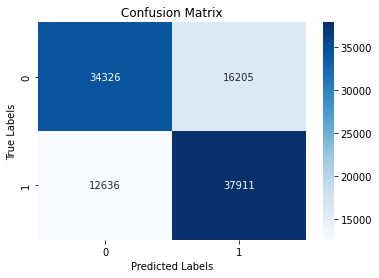

In [ ]:
matrix = confusion_matrix(valid['label'], valid_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

## **Method 2: Use 5 features - including comment_processed, punctuation_frequency etc., to fit into the model**

### Vectorize comments and numerical values seperately, then use hstack to combine

In [ ]:
tfidf_train_words = tfidf.fit_transform(train['lemmatized'])
train_stats = train[['score', 'word_count', 'capitilised_frequency', 'punctuation_frequency']]
tfidf_train_vector = hstack([tfidf_train_words, train_stats.values])

### Fit training data and labels into linear_svm model

In [ ]:
linear_svm.fit(tfidf_train_vector, train['label'])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

### Preparing validation data to fit into model

In [ ]:
tfidf_valid_words = tfidf.transform(valid['lemmatized'])
valid_stats = valid[['score', 'word_count', 'capitilised_frequency', 'punctuation_frequency']]
tfidf_valid_vector = hstack([tfidf_valid_words, valid_stats.values])

### Evaluation on validation data

In [ ]:
valid_pred_2 = linear_svm.predict(tfidf_valid_vector)
accuracy_score(valid['label'], valid_pred_2)

0.7143493143908665

In [ ]:
print(classification_report(valid['label'], valid_pred_2, labels=[0, 1], digits=3))

              precision    recall  f1-score   support

           0      0.709     0.727     0.718     50547
           1      0.720     0.702     0.711     50531

    accuracy                          0.714    101078
   macro avg      0.714     0.714     0.714    101078
weighted avg      0.714     0.714     0.714    101078



Text(33.0, 0.5, 'True Labels')

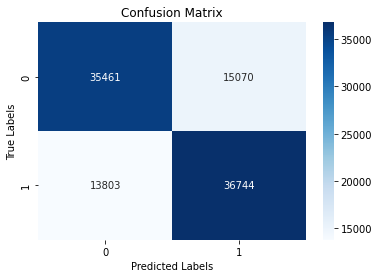

In [ ]:
matrix = confusion_matrix(valid['label'], valid_pred_2, labels=[1,0])
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Predicting on test data

Since the original pipeline achieved the same accuracy as when we used 5 features, we used the original pipeline(METHOD 1) as it has fewer features and takes a shorter time to train.

# Evaluation on Test set

We used method 1 as both methods performed similarly, but 

In [ ]:
tfidf_pipeline.fit(train_valid['lemmatized'], train_valid['label'])
test_pred = tfidf_pipeline.predict(test['lemmatized'])
accuracy_score(test['label'], test_pred)

0.717823159534806

In [ ]:
print(classification_report(test['label'], test_pred, labels=[1,0], digits=3))

              precision    recall  f1-score   support

           1      0.734     0.683     0.708    125795
           0      0.704     0.752     0.727    125799

    accuracy                          0.718    251594
   macro avg      0.719     0.718     0.717    251594
weighted avg      0.719     0.718     0.717    251594



Text(33.0, 0.5, 'True Labels')

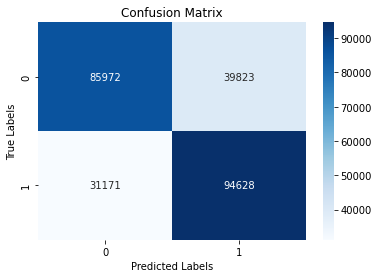

In [ ]:
matrix = confusion_matrix(test['label'], test_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

**Both validation and test sets yield a similar accuracy of ~71% for method 1**